In [1]:
import numpy as np
import torch
import taichi as ti
import taichi.math as tm
import importlib
import scipy
import time
import matplotlib
from math import prod

ti.init(arch=ti.cpu, debug=True)

ti_float = ti.f32
torch_float = torch.float32
# ti.init(arch=ti.cpu, kernel_profiler=True)

[Taichi] version 1.7.1, llvm 15.0.4, commit 0f143b2f, linux, python 3.11.6


[I 05/16/24 09:21:08.791 176907] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=x64


In [2]:
@ti.data_oriented
class ParticleSystem:
    def __init__(
        self,
        *,
        n_particles,
        particle_type,
        domain,
        blocksize=None,
        integral_dimension=0,
    ):
        self.__dict__["particle_type"] = particle_type

        self.integral_dimension = integral_dimension

        self.domain = domain.type(torch.int32)
        # Check that the domain is binary
        if not ((self.domain == 0) | (self.domain == 1)).all():
            raise ValueError("The domain must be a binary mask.")

        self.shape = self.domain.shape
        self.device = self.domain.device

        # Make sure that our code is compatible with both 2D and 3D domains
        if len(self.shape) == 2:
            self.dim = 2
            ind = ti.ij
            self.i32vector = ti.types.vector(2, ti.i32)
            self.segment_connectivity = [(1, 0), (0, 1)]
        elif len(self.shape) == 3:
            self.dim = 3
            ind = ti.ijk
            self.i32vector = ti.types.vector(3, ti.i32)
            self.segment_connectivity = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
        else:
            raise ValueError("Only 2D and 3D domains are supported.")

        # We use a periodic domain in the Jump Flooding Algorithm
        # (but by default, we do not use periodic costs).
        # This means that we need to compute the modulo of the indices
        # with respect to the domain shape, which can be expensive
        # for non-power-of-two shapes.
        self.power_of_two = all((n & (n - 1) == 0) and n != 0 for n in self.shape)
        if self.power_of_two:
            # Use the fact that e.g. n % 8 = n & 00000111 = n & 7 in binary
            self.bitwise_modulo = self.i32vector(self.shape) - 1
        else:
            self.bitwise_modulo = None
            print("Warning: the domain shape is not a power of two.")

        # Create the collection of particles, with an additional particle
        # for the ambient space.
        self.cells = particle_type.field(shape=(1 + n_particles,))

        # By default, all particles have zero offset and unit scaling.
        # Most users won't touch the scaling, but the offset is used by the semi-discrete
        # optimal transport solver to enforce volume constraints on the Laguerre cells.
        # N.B.: The two lines below actually use the __setattr__ method,
        #       which target the attributes of self.cells[1:].
        self.offset = torch.zeros(n_particles, dtype=torch_float, device=self.device)
        self.scaling = torch.ones(n_particles, dtype=torch_float, device=self.device)

        # Create the grid of pixels, and the intermediate buffer
        # that will be used in the Jump Flooding Algorithm
        self.pixels = ti.field(ti.i32)
        self.pixels_buffer = ti.field(ti.i32)

        if blocksize is None:
            # By default, the pixel grids are just vanilla C-contiguous arrays.
            ti.root.dense(ind, self.shape).place(self.pixels)
            ti.root.dense(ind, self.shape).place(self.pixels_buffer)
        else:
            # But Taichi also lets us encode them as collections of square patches.
            # This can be useful for performance, especially on GPUs.
            coarse = tuple(s // blocksize for s in self.shape)
            block = tuple(blocksize for _ in self.shape)
            # The lines below mean that the pixel grids are now stored as
            # a collection of square patches of size (blocksize, blocksize).
            ti.root.dense(ind, coarse).dense(ind, block).place(self.pixels)
            ti.root.dense(ind, coarse).dense(ind, block).place(self.pixels_buffer)

    @property
    def n_cells(self):
        return self.cells.shape[0]

    @property
    def n_seeds(self):
        return self.n_cells - 1

    def __getattr__(self, attr):
        """Give direct access to the attributes of self.cells, minus the ambient space."""
        if attr in self.__dict__["particle_type"].__dict__["members"].keys():
            out = getattr(self.cells, attr)
            out = out.to_torch()
            out = out[1:]
            return out
        else:
            return self.__dict__[attr]

    def __setattr__(self, attr, value):
        """Give direct access to the attributes of self.cells, minus the ambient space."""
        if attr in self.particle_type.__dict__["members"].keys():
            # N.B.: All the attributes of the ambient space are set to zero.
            val = torch.cat([torch.zeros_like(value[:1]), value])
            getattr(self.cells, attr).from_torch(val)
        else:
            self.__dict__[attr] = value

    @ti.func
    def wrap_indices(self, pos):
        """Ensures periodic boundary conditions for the Jump Flooding Algorithm."""
        # Modulo the indices to have periodic boundary conditions
        if ti.static(self.power_of_two):
            # Use the fact that e.g. n % 8 = n & 00000111 = n & 7 in binary
            return pos & self.bitwise_modulo
        else:
            return ti.cast(tm.mod(pos, self.shape), ti.i32)

    @ti.kernel
    def compute_cells_bruteforce(self):
        """For each pixel, compute the index of the cell with the lowest cost."""

        for X in ti.grouped(self.pixels):
            best_cost = ti_float(1e10)
            best_index = 0  # Ambient space by default

            for i in ti.ndrange(self.cells.shape[0]):
                # N.B.: the cell cost function takes as input a float32 vector
                #       with integer coordinates
                cost = self.cells[i].cost(ti.cast(X, dtype=ti_float))
                if cost < best_cost:
                    best_cost = cost
                    best_index = i

            self.pixels[X] = best_index

    @ti.kernel
    def init_sites(self):
        """Puts one pixel per seed in the pixel grid."""
        # Clear the pixels grid:
        for I in ti.grouped(self.pixels):
            self.pixels[I] = 0  # Ambient space by default

        # Place one pixel per seed.
        # Note that we must be careful here to have at least one pixel per cell:
        # otherwise, the JFA algorithm will not work as expected.
        # For this reason, we should not run the seeding in parallel:
        # ti.loop_config(serialize=True)
        for i in self.cells:
            if i > 0:  # Skip the ambient space
                # Cast the position to integers, using floor instead of round
                pos = tm.floor(self.cells[i].position, dtype=ti.i32)
                # Wrap the indices to have periodic boundary conditions
                # This is also useful if the user provided cells that lay outside
                # the domain
                pos = self.wrap_indices(pos)

                if self.pixels[pos] == 0:  # If the pixel is not already taken
                    self.pixels[pos] = i  # Assign the seed index to the pixel
                else:  # Collision!
                    # As a quick fix, we look for the nearest free pixel in
                    # a neighborhood of increasing size.
                    pos2 = pos
                    for l in range(1, 10):
                        for dpos in ti.grouped(
                            ti.ndrange(*(((-l, l + 1),) * self.dim))
                        ):
                            pos2 = pos + ti.cast(dpos, dtype=ti.i32)
                            pos2 = self.wrap_indices(pos2)
                            if self.pixels[pos2] == 0:
                                self.pixels[pos2] = i
                                break
                        if self.pixels[pos2] == i:
                            break

                    assert (
                        self.pixels[pos2] == i
                    ), f"Could not find a free pixel for seed {i}."

    @ti.func
    def _clear_buffer(self):
        for I in ti.grouped(self.pixels_buffer):
            self.pixels_buffer[I] = 0  # Set all pixels to ambient space

    @ti.func
    def _copy_buffer(self):
        for I in ti.grouped(self.pixels):
            self.pixels[I] = self.pixels_buffer[I]

    @ti.kernel
    def jfa_step(self, step: ti.i32):
        """Implements one step of the Jump Flooding Algorithm."""
        self._clear_buffer()

        for X in ti.grouped(self.pixels):
            # Loop over 9 neighbors at distance step
            # and find the closest seed to the current pixel [i,j]
            best_cost = 1e10
            best_index = 0  # Ambient space by default

            ti.loop_config(serialize=True)  # Unroll the loop of size 3^dim
            for DX in ti.grouped(ti.ndrange(*(((-1, 2),) * self.dim))):
                # Describe a 3^dim neighborhood around the current pixel,
                # with periodic boundary conditions
                X2 = X + step * ti.cast(DX, ti.i32)
                X2 = self.wrap_indices(X2)

                # Check if the cost function that is associated to X2 is a better
                # fit for the current pixel than the previous best candidate:
                i2 = self.pixels[X2]
                # N.B.: the cell cost function takes as input a float32 vector
                #       with integer coordinates
                cost = self.cells[i2].cost(ti.cast(X, dtype=ti_float))
                if cost < best_cost:
                    best_cost = cost
                    best_index = i2

            # We must use an intermediate buffer to avoid overwriting the pixels
            # while the main loop is still running
            self.pixels_buffer[X] = best_index

        self._copy_buffer()

    @ti.kernel
    def _cell_centers_volumes(
        self,
        centers: ti.types.ndarray(dtype=ti_float, element_dim=0),
        volumes: ti.types.ndarray(dtype=ti_float, element_dim=0),
    ):
        """Computes in place the barycenter and volume of each cell."""
        for X in ti.grouped(self.pixels):
            i = self.pixels[X]
            if i >= 0:  # Ignore the mask, i == -1
                for d in ti.static(range(self.dim)):
                    centers[i, d] += ti.cast(X[d], ti_float)
                volumes[i] += 1.0

        for i in ti.ndrange(self.n_cells):
            for d in ti.static(range(self.dim)):
                if volumes[i] > 0:
                    centers[i, d] /= volumes[i]
                else:
                    centers[i, d] = 0.0

    @ti.kernel
    def _corrective_terms_1D(
        self,
        volume_corrections: ti.types.ndarray(dtype=ti_float, element_dim=0),
        ot_hessian: ti.types.ndarray(dtype=ti_float, element_dim=0),
    ) -> ti_float:
        out = ti_float(0.0)
        for X in ti.grouped(self.pixels):
            for dpos in ti.static(self.segment_connectivity):
                Y = X + ti.cast(dpos, dtype=ti.i32)
                Y = self.wrap_indices(Y)

                i = self.pixels[X]  # Index of the best cell at pixel X
                j = self.pixels[Y]  # Index of the best cell at pixel Y

                # Are we on the boundary between two cells?
                if i != j and i != -1 and j != -1:  # Exclude the mask
                    # Compute the costs of the two cells at the two pixels
                    # By definition of i, Mx >= mx
                    Mx = self.cells[j].cost(ti.cast(X, dtype=ti_float))
                    mx = self.cells[i].cost(ti.cast(X, dtype=ti_float))
                    hx = Mx - mx  # >= 0

                    # By definition of j, My >= my
                    My = self.cells[i].cost(ti.cast(Y, dtype=ti_float))
                    my = self.cells[j].cost(ti.cast(Y, dtype=ti_float))
                    hy = My - my  # >= 0

                    if hx > 0 and hy > 0:
                        f = 1 / (hx + hy)
                        out += .5 * f * hx * hy
                        volume_corrections[i] += .5 * f * (hx - hy)
                        volume_corrections[j] += .5 * f * (hy - hx)
                        ot_hessian[i, i] += f
                        ot_hessian[j, j] += f
                        ot_hessian[i, j] -= f
                        ot_hessian[j, i] -= f

        return out

    @ti.kernel
    def _apply_mask(
        self,
        mask: ti.types.ndarray(dtype=ti.i32, element_dim=0),
    ):
        """Sets to -1 the pixel labels where the mask is zero."""
        for X in ti.grouped(self.pixels):
            self.pixels[X] = ti.select(mask[X], self.pixels[X], -1)

    def compute_cells(
        self,
        init_step=None,
        n_steps=None,
        method="bruteforce",
    ):
        # We expect that the exact bruteforce method will be faster
        # when the number of cells is small (< 1000 ?)
        if method == "bruteforce":
            self.compute_cells_bruteforce()

        # The Jump Flooding Algorithm is more efficient for a large number of cells,
        # especially if we use a power-of-two domain and a small-ish init_step like
        # 16 or 32.
        elif method == "JFA":
            # Create a list of steps that looks like
            # [1, N/2, N/4, N/8, ... 1]
            steps = [1]  # Start with a step of 1, aka. "1+JFA"
            if init_step is None:
                init_step = int(np.ceil(max(self.shape) // 2))

            n = init_step
            while n > 0:
                steps.append(n)
                n = int(np.ceil(n // 2))

            # Limit the number of steps if required, typically for debugging
            if n_steps is not None:
                steps = steps[:n_steps]

            # Initialize the pixel grid with the seed positions
            self.init_sites()

            # Run the Jump Flooding Algorithm
            for step in steps:
                self.jfa_step(step)
        else:
            raise ValueError(f"Unknown method {method}.")

        # Set pixel labels to -1 wherever domain == 0
        self._apply_mask(self.domain)

        # Compute basic information (centers and volumes) about the cells
        self.cell_centers = torch.zeros(
            (self.n_cells, self.dim), dtype=torch_float, device=self.device
        )
        self.cell_volumes = torch.zeros(
            self.n_cells, dtype=torch_float, device=self.device
        )
        self._cell_centers_volumes(self.cell_centers, self.cell_volumes)

        # Estimation of the integral of the min-cost function over the domain
        # and volumes if the uniform measure on the domain is approximated
        # by a sum of Dirac masses at the pixel centers,
        # i.e. elements of dimension 0.
        self.cost_integral = (self.pixel_costs * self.domain).sum()

        # If dimension == 1, we use 1D elements that correspond to the segments
        # between adjacent pixels, along the axes of the 1D, 2D or 3D domain.
        # Assuming a piecewise linear model for the cost function,
        # direct computations show that we must add corrective terms to the
        # cost_integral along the boundaries of the cell,
        # and correct the cell volumes as well.
        if self.integral_dimension == 1:
            volume_corrections = torch.zeros_like(self.cell_volumes)
            ot_hessian = torch.zeros(
                (1 + self.n_seeds, 1 + self.n_seeds),
                dtype=torch_float,
                device=self.device,
            )
            cost_correction = self._corrective_terms_1D(volume_corrections, ot_hessian)
            self.cell_volumes += volume_corrections / self.dim
            self.cost_integral += cost_correction / self.dim
            self.ot_hessian = ot_hessian[1:,1:] / self.dim

    def volume_fit(
        self,
        max_iter=100,
        rtol=1e-2,
        atol=2,
        verbose=False,
        barrier=10,
        warm_start=False,
        stopping_criterion="average",
        method="Newton",
    ):
        n_pixels = prod(self.shape)

        if warm_start:
            seed_potentials = -self.offset
        else:
            seed_potentials = torch.zeros(
                self.n_seeds, dtype=torch_float, device=self.device
            )

        if self.volume is None:
            raise ValueError("The volume of the cells must be set.")

        # Check that the problem is feasible
        available_volume = self.domain.sum().item()
        sum_target_volume = self.volume.sum().item()
        if sum_target_volume > available_volume:
            raise ValueError(
                f"The target volume of the cells ({sum_target_volume})"
                f"exceeds the available volume ({available_volume})."
            )

        # There is no need to require grads, since we will compute the gradient manually:
        # seed_potentials.requires_grad = True

        if method == "Newton":
            # Use Newton's method with an explicit Hessian as in papers by
            # Quentin Merigot, Bruno Levy, etc.
            # This only works when integral_dimension == 1.
            if self.integral_dimension != 1:
                raise ValueError(
                    "Newton's method is only available when "
                    "self.integral_dimension == 1."
                )

            barrier = None  # for the moment, keep things simple

            if False:
                optimizer = torch.optim.SGD([seed_potentials], lr=1)
            else:
                # Small hack: use the LBFGS optimizer with max_iter = 1
                # to get access to a good line search algorithm.
                optimizer = torch.optim.LBFGS(
                    [seed_potentials],
                    lr=1,
                    line_search_fn="strong_wolfe",
                    tolerance_grad=(atol + rtol * self.volume.min()) / (n_pixels),
                    tolerance_change=1e-20,
                    max_iter=1,
                )

            def step(closure, current_value):
                nonlocal seed_potentials
                
                grad = seed_potentials.grad
                hessian = self.ot_hessian / n_pixels
                #print(hessian)
                #print(grad)
                hessian = hessian + 1e-6 * torch.eye(self.n_seeds, device=self.device)
                # We solve the linear system Hessian * delta = -grad
                direction = torch.linalg.solve(hessian, -grad)

                if False:
                    # Implement line search
                    t = 1
                    old_potentials = seed_potentials.clone()
                    while True:
                        seed_potentials = old_potentials + t * direction
                        new_value = closure()
                        if new_value < current_value:
                            break
                        t /= 2
                        if t < 1e-8:
                            break
                else:
                    seed_potentials.grad = -direction
                    optimizer.step(closure=closure)
                    new_value = closure()

                if verbose:
                    print(":", end="", flush=True)
                return new_value

            n_outer_iterations = max_iter

        elif method == "L-BFGS-B":
            # We use LBFGS here as it is both simple and versatile.
            # The tolerance on the gradient corresponds to a stopping
            # criterion for the inner loop of LBFGS.
            # This threshold is applied to the maximum of the absolute values of the gradient
            # coordinates: we choose a value that corresponds to a conservative relative error
            optimizer = torch.optim.LBFGS(
                [seed_potentials],
                lr=1,
                line_search_fn="strong_wolfe",
                tolerance_grad=(atol + rtol * self.volume.min()) / (n_pixels),
                tolerance_change=1e-20,
                max_iter=max_iter,
            )

            def step(closure):
                optimizer.step(closure=closure)
            
            n_outer_iterations = 10

        def closure():
            optimizer.zero_grad()
            # If NaN, throw an error
            if torch.isnan(seed_potentials).any():
                raise ValueError("NaN detected in seed potentials.")

            # Replace the cost function c_i(x) (e.g. = |x-x_i|^2)
            # with a biased version c_i(x) - seed_potentials[i]
            self.offset = -seed_potentials
            # Compute the Laguerre cells using the jump flooding algorithm
            self.compute_cells()

            # Compute the concave, dual objective of the semi-discrete optimal transport
            # problem (which is actually discrete-discrete here, since we use pixels
            # instead of proper Voronoi-Laguerre cells)
            # First term: \sum_i v_i * f_i
            # (without the volume of the ambient space, that is associated to
            # a potential of zero)
            loss = (self.volume * seed_potentials).sum()
            # Second term: integral of the min-cost function over the domain.
            # Recall that domain is a binary mask, and
            # self.pixel_costs[x] = min_i ( c_i(x) - seed_potentials[i] )
            loss = loss + self.cost_integral

            # The gradient of the loss function is the difference between the current
            # cell volumes and the target volumes. We normalize by the number of pixels
            # to get meaningful values and gradients in the optimization.
            # (Keeping things of order 1 is probably a good idea for numerical stability
            # and compatibility with default optimizer settings.)
            seed_potentials.grad = (self.cell_volumes[1:] - self.volume) / n_pixels

            # We return minus the concave loss function, since LBFGS is a minimizer
            # and not a maximizer.
            convex_loss = -loss / n_pixels

            if barrier is not None:
                # Add a barrier to prevent the potentials from becoming negative,
                # which would correspond to a negative volume.
                # This prevents L-BFGS from going too far in the wrong direction.
                # We use a simple quadratic barrier, but other choices are possible.
                # The barrier is only active when the potentials are positive.
                # We use a small value to avoid numerical issues.
                barrier_loss = 0.5 * (seed_potentials.clamp(max=0) ** 2).sum()
                convex_loss += barrier * barrier_loss

                barrier_gradient = seed_potentials.clamp(max=0)
                seed_potentials.grad += barrier * barrier_gradient

            if verbose:
                print(f".", end="", flush=True)

            return convex_loss

        current_value = closure()

        # Actual optimization loop
        if verbose:
            print(f"Dual cost: {-current_value.item():.15e} ", end="", flush=True)

        converged = False
        for it in range(n_outer_iterations):
            current_value = step(closure, current_value)

            if verbose:
                l = current_value.item()
                print(f"{-l:.15e}", end="", flush=True)

            error = (self.cell_volumes[1:] - self.volume).abs()
            threshold = atol + rtol * self.volume.abs()

            if stopping_criterion == "average":
                stop = error.mean() < threshold.mean()
            else:
                stop = (error < threshold).all()

            
            rel_error = error / self.volume
            if verbose:
                print(
                    f" -> {100 * rel_error.max():.2f}% max error, {100 * rel_error.mean():.2f}% mean error"
                )

            if stop:
                converged = True
                break
            elif method == "L-BFGS-B":
                print("")

        rel_error = error / self.volume
        if verbose:
            print(
                f" -> {100 * rel_error.max():.2f}% max error, {100 * rel_error.mean():.2f}% mean error"
            )

        if not stop:
            # Throw a warning if the optimization did not converge
            print("Warning: optimization did not converge.")

        # To be sure, we recompute the cells with the final seed potentials
        self.offsets = -seed_potentials
        self.compute_cells()
        return converged

    def pixel_colors(self, c=None, cmap="Spectral"):

        if c is None:
            c = np.linspace(0, 1, self.n_cells)
        else:
            c = c.type(torch.float64).detach().cpu().numpy()

        cmap = matplotlib.colormaps[cmap]
        cell_colors = cmap(c)[:, :3].astype(np.float32)
        cell_colors = torch.from_numpy(cell_colors).to(self.device)

        canvas = cell_colors[self.pixel_labels - 1]
        # Set the ambient space to white
        canvas[self.pixel_labels == 0] = 1
        # Set the mask to black
        canvas[self.pixel_labels == -1] = 0
        return canvas

    @property
    def pixel_labels(self):
        return self.pixels.to_torch()

    @ti.kernel
    def _pixel_costs(self, canvas: ti.types.ndarray(dtype=ti_float, element_dim=0)):
        for I in ti.grouped(canvas):
            index = self.pixels[I]
            if index >= 0:
                canvas[I] = self.cells[index].cost(ti.cast(I, dtype=ti_float))
            else:
                canvas[I] = 0.0

    @property
    def pixel_costs(self):
        canvas = torch.zeros(self.shape, dtype=torch_float)
        self._pixel_costs(canvas)
        return canvas

    @ti.kernel
    def _contours(
        self, canvas: ti.types.ndarray(dtype=ti.i32, element_dim=0), linewidth: ti.i32
    ):
        for X in ti.grouped(self.pixels):
            ref = self.pixels[X]
            canvas[X] = 0
            ti.loop_config(serialize=True)  # Unroll the loop over the neighborhood
            for DX in ti.grouped(
                ti.ndrange(*(((-linewidth, linewidth + 1),) * self.dim))
            ):
                X2 = X + ti.cast(DX, ti.i32)
                X2 = tm.clamp(X2, 0, self.shape - self.i32vector(1, 1))
                # The pixel that gets contoured is the one with the smallest index,
                # typically the ambient space (index 0) but we exclude the mask (index -1)
                if self.pixels[X2] > ref and ref >= 0:
                    canvas[X] = 1

    def contours(self, linewidth=1):
        canvas = torch.zeros(self.shape, dtype=torch.int32)
        self._contours(canvas, linewidth=linewidth)
        return canvas

    def render(self, c=None, cmap="Spectral", linewidths=1):
        canvas = self.pixel_colors(c=c, cmap=cmap)
        if linewidths > 0:
            canvas[self.contours(linewidth=linewidths) == 1] = 0
            # [0, 0, 0, 1]
        return canvas

In [3]:
@ti.dataclass
class PowerCell2D:
    """This class implements an isotropic power cell."""
    # Custom parameters for the cell
    position: ti.types.vector(2, ti_float)
    power: ti_float

    # Parameters required by our semi-discrete OT solver
    volume: ti_float  # Desired volume for the cell, in pixels
    scaling: ti_float  # Scaling factor for the cost function
    offset: ti_float  # Additive offset for the cost function

    @ti.func
    def cost(self, pixel):
        dist = (self.position.x - pixel.x) ** 2 + (self.position.y - pixel.y) ** 2
        dist = dist ** (self.power / 2)
        return self.scaling * dist + self.offset
    
@ti.dataclass
class AnisotropicPowerCell2D:
    """This class implements an anisotropic power cell."""
    # Custom parameters for the cell
    position: ti.types.vector(2, ti_float)
    precision_matrix: ti.types.matrix(2, 2, ti_float)
    power: ti_float

    # Parameters required by our semi-discrete OT solver
    volume: ti_float  # Desired volume for the cell, in pixels
    scaling: ti_float  # Scaling factor for the cost function
    offset: ti_float  # Additive offset for the cost function

    @ti.func
    def cost(self, pixel):
        #dist = (self.position.x - pixel.x) ** 2 + (self.position.y - pixel.y) ** 2
        dist = (self.position - pixel).dot(self.precision_matrix @ (self.position - pixel))
        dist = dist ** (self.power / 2)
        return self.scaling * dist + self.offset

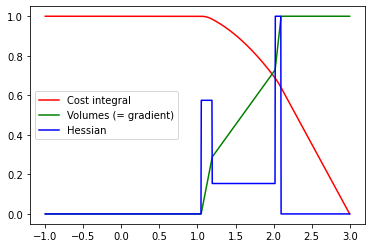

In [4]:
# Create a very simple problem with one cell (+ ambient space),
# and check that the cost function, volume and hessian all look correct.

from matplotlib import pyplot as plt

N, n_particles = 2, 1
Nx, Ny, Nz = N, N, N

X, Y = torch.meshgrid(torch.arange(Nx), torch.arange(Ny), indexing="ij")
domain = (X - Nx / 2) ** 2 + (Y - Ny / 2) ** 2 < 4 * (Nx * Ny) / 4

particles = ParticleSystem(
    n_particles=n_particles,
    particle_type=PowerCell2D,
    domain=domain,
    integral_dimension=1,
)

labels = torch.linspace(0, 1, n_particles, dtype=torch_float)
labels = 1 * (labels > 0.5)

powers = torch.tensor([1.0, 2.0], dtype=torch_float)
volumes = torch.tensor([0.5, 0.5], dtype=torch_float) * (Nx * Ny) / n_particles

particles.position = N * torch.rand((n_particles, 2), dtype=torch_float)
particles.power = powers[labels]
particles.volume = volumes[labels]

potentials = np.linspace(-1, 1.5 * N, 1000)
costs = []
volumes = []
hessians = []

for potential in potentials:
    particles.offset = -potential * torch.ones(n_particles, dtype=torch_float)
    particles.compute_cells()
    costs.append(particles.cost_integral / (N * N))
    volumes.append(particles.cell_volumes[1])
    hessians.append(particles.ot_hessian[0, 0])

# Plot the cost integral and the volumes with two different scales

costs = torch.tensor(costs)
volumes = torch.tensor(volumes)
hessians = torch.tensor(hessians)

# Normalize the costs, volumes, hessians to plot them on the same graph
costs = costs - costs.min()
costs = costs / costs.max()
volumes = volumes - volumes.min()
volumes = volumes / volumes.max()
hessians = hessians - hessians.min()
hessians = hessians / hessians.max()

plt.plot(potentials, costs, "red", label="Cost integral")
plt.plot(potentials, volumes, "green", label="Volumes (= gradient)")
plt.plot(potentials, hessians, "blue", label="Hessian")

plt.legend()
plt.show()

In [16]:
particles.pixels.to_torch()

tensor([[1, 1],
        [1, 1]], dtype=torch.int32)

.Dual cost: 0.000000000000000e+00 ........:6.634497070312500e+01 -> 83.62% max error, 64.62% mean error
...:1.561907806396484e+02 -> 100.18% max error, 50.81% mean error
...:2.654279174804688e+02 -> 413.25% max error, 80.16% mean error
...:3.520836181640625e+02 -> 314.67% max error, 72.98% mean error
...:4.022955322265625e+02 -> 186.18% max error, 57.12% mean error
...:4.305054931640625e+02 -> 123.58% max error, 37.34% mean error
...:4.448840332031250e+02 -> 141.04% max error, 28.05% mean error
...:4.486210937500000e+02 -> 111.05% max error, 17.47% mean error
...:4.503833007812500e+02 -> 48.12% max error, 10.65% mean error
...:4.511859130859375e+02 -> 28.45% max error, 6.01% mean error
...:4.515358886718750e+02 -> 28.80% max error, 4.48% mean error
...:4.517664794921875e+02 -> 29.47% max error, 3.60% mean error
...:4.518656005859375e+02 -> 7.81% max error, 2.33% mean error
...:4.519130859375000e+02 -> 4.89% max error, 1.71% mean error
...:4.519495849609375e+02 -> 6.61% max error, 1.59%

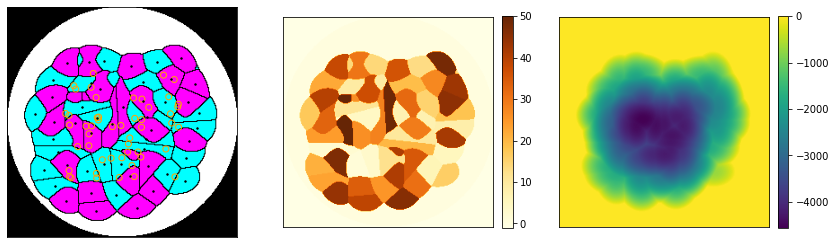

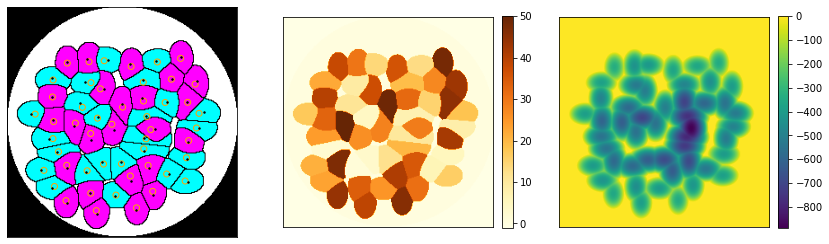

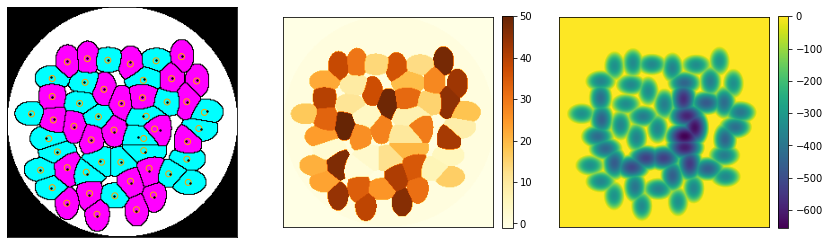

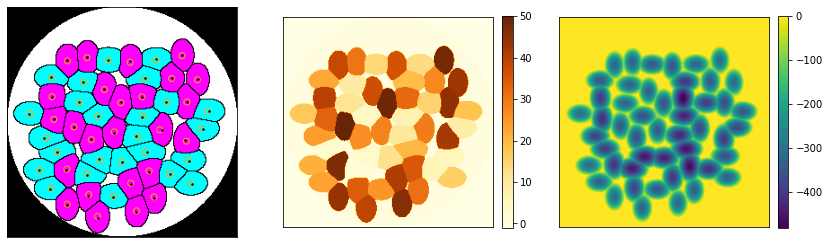

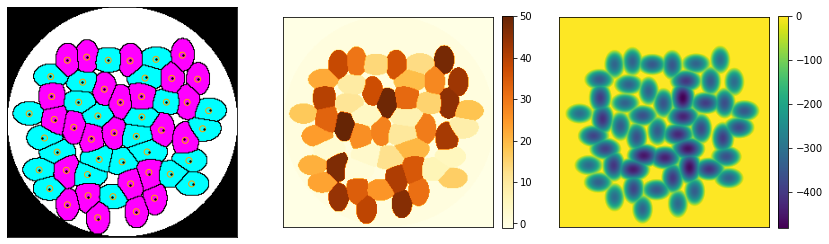

In [5]:
import time
from matplotlib import pyplot as plt

N, n_particles = 256, 50
Nx, Ny, Nz = N, N, N

X, Y = torch.meshgrid(torch.arange(Nx), torch.arange(Ny), indexing="ij")
domain = (X - Nx / 2) ** 2 + (Y - Ny / 2) ** 2 < (Nx * Ny) / 4

particles = ParticleSystem(
    n_particles=n_particles,
    particle_type=AnisotropicPowerCell2D,
    domain=domain,
    integral_dimension=1,
)

# Define two populations of particles:
labels = torch.linspace(0, 1, n_particles, dtype=torch_float)
labels = 1 * (labels > 0.5)

powers = torch.tensor([2.0, 2.0], dtype=torch_float)
volumes = torch.tensor([0.5, 0.5], dtype=torch_float) * (Nx * Ny) / n_particles
precisions = torch.stack(
    [
        torch.tensor([[2.0, 0.0], [0.0, 1.0]], dtype=torch_float),
        torch.tensor([[1.0, 0.0], [0.0, 2.0]], dtype=torch_float),
    ]
)

# Load the particles with our desired attributes:
particles.position = N * (.25 + .5 * torch.rand((n_particles, 2), dtype=torch_float))
particles.precision_matrix = precisions[labels]
particles.power = powers[labels]
particles.volume = volumes[labels]

particles.offset = -0 * torch.ones(n_particles, dtype=torch_float)


start = time.time()

for it in range(5):
    if it > 0:
        pos = particles.cell_centers[1:]
        # pos[:, 0] -= 2
        particles.position = pos.clamp(0, N - 1)

    converged = particles.volume_fit(
        max_iter=30,
        rtol=0.001,
        atol=5,
        verbose=True,
        warm_start=True,
        barrier=10,
        method="Newton",
        stopping_criterion="average",
    )
    end = time.time()
    # print("Time:", end - start)

    if it % 1 == 0:  # or not converged:
        plt.figure(figsize=(14, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(
            particles.render(c=labels, cmap="cool", linewidths=1),
            extent=(0, Ny, Nx, 0),
        )
        plt.scatter(
            particles.position[:, 1],
            particles.position[:, 0],
            edgecolors="orange",
            facecolors="none",
            s=36,
        )
        plt.scatter(
            particles.cell_centers[1:, 1], particles.cell_centers[1:, 0], c="k", s=2
        )
        plt.axis([0, Nx, 0, Ny])
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 2)
        plt.imshow(particles.pixel_labels, extent=(0, Ny, Nx, 0), cmap="YlOrBr")
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis([0, Nx, 0, Ny])
        plt.xticks([])
        plt.yticks([])

        plt.subplot(1, 3, 3)
        plt.imshow(particles.pixel_costs, extent=(0, Ny, Nx, 0))
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.axis([0, Nx, 0, Ny])
        plt.xticks([])
        plt.yticks([])


plt.show()

In [6]:
print(particles.volume)
print(particles.cell_volumes)

tensor([655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600,
        655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600,
        655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600,
        655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600,
        655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600,
        655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600,
        655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600, 655.3600,
        655.3600])
tensor([18116.2891,   657.0394,   655.7322,   673.5502,   673.5728,   684.3347,
          662.5790,   666.4523,   665.9326,   679.5010,   662.3761,   657.3134,
          661.6105,   657.6232,   668.5190,   662.2483,   669.2407,   666.4795,
          660.1256,   668.4977,   664.3149,   672.2731,   666.6964,   665.5788,
          656.7159,   656.6882,   671.7717,   664.5289,   666.4767,   668.7062,
          665.9509,   688.6495,   6

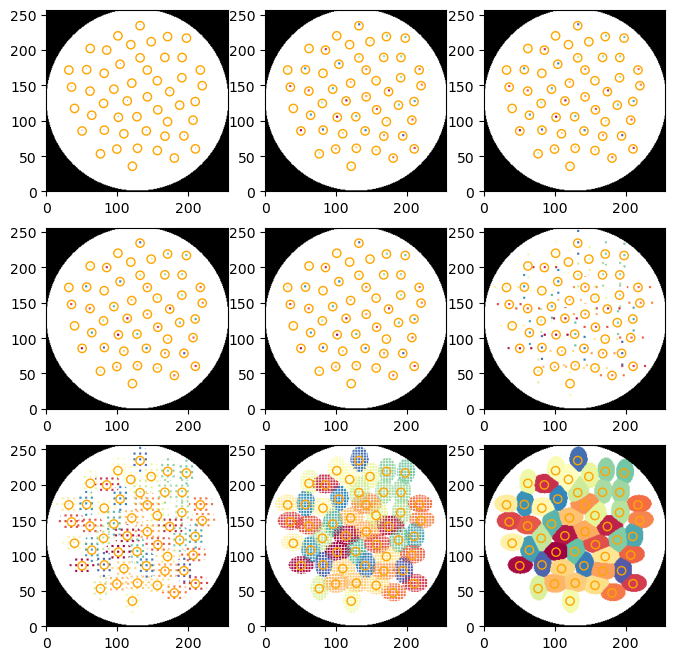

In [7]:
# Illustrate the Jump Flooding Algorithm, whose complexity does
# not depend on the number of cells, but only on the domain size.
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i + 1)
    particles.compute_cells(method = "JFA", n_steps=i)
    plt.imshow(particles.render(linewidths=0), extent=(0, Ny, Nx, 0))
    plt.scatter(
        particles.position[:, 1],
        particles.position[:, 0],
        edgecolors="orange",
        facecolors="none",
        s=36,
    )
    # plt.scatter(seed_positions[:, 1], seed_positions[:, 0], c="r", s=2)
    # plt.scatter(cells.centers[:, 1], cells.centers[:, 0], c="k", s=2)
    # Set axis boundaries
    plt.axis([0, Nx, 0, Ny])